In [1]:
import sys
sys.path.append("../")

import os
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2

from utils.config_util import load_config
# from data.augmentation import batch_transform

In [2]:
def batch_transform(img_h, img_w):
    transform = A.Compose([
        # A.Compose([
        #     A.LongestMaxSize(max_size=max(img_h, img_w), p=1),
        #     A.PadIfNeeded(min_height=img_h, min_width=img_w, border_mode=0, value=(255, 255, 255), p=1),
        # ], p=1),

        A.Resize(height=img_h, width=img_w),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    return transform

In [3]:
def deskew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    angle = 0
    if lines is not None:
        for rho, theta in lines[0]:
            angle = theta * 180 / np.pi - 90
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

In [4]:
def get_last_conv_name(model):
    for name, m in model.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            last_conv_name = name
    return last_conv_name


class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.target_layer = dict([*self.model.named_modules()])[self.layer_name]
        
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, class_idx=None):
        b, c, h, w = x.size()
        
        logit = self.model(x)
        probs = F.softmax(logit, dim=1)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
            predicted_class = logit.max(1)[-1].item()
            predicted_prob = probs[0, predicted_class].item()
        else:
            score = logit[:, class_idx].squeeze()
            predicted_class = class_idx
            predicted_prob = probs[0, class_idx].item()
        
        self.model.zero_grad()
        score.backward(retain_graph=True)
        
        gradients = self.gradients.mean([2, 3], keepdim=True)
        activations = self.activations
        
        weights = gradients * activations
        weights = F.relu(weights)
        
        heatmap = weights.sum([1], keepdim=True)
        heatmap = F.interpolate(heatmap, (h, w), mode='bilinear', align_corners=False)
        
        heatmap = heatmap.squeeze().cpu().numpy()
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        
        return heatmap, predicted_class, predicted_prob


def apply_heatmap(img, heatmap):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    return heatmap


def visualize_grad_cam(model, img_tensor, class_idx=None, overlay=False):
    model.eval()
    
    last_conv_name = get_last_conv_name(model)
    grad_cam = GradCAM(model, last_conv_name)
    
    heatmap, predicted_class, predicted_prob = grad_cam(img_tensor.unsqueeze(0), class_idx)
    
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    
    # 히트맵 생성
    colored_heatmap = apply_heatmap(img, heatmap)
    
    if overlay:
        cam = colored_heatmap + img
        cam = cam / np.max(cam)
        return np.uint8(255 * cam), predicted_class, predicted_prob
    else:
        return img, np.uint8(255 * colored_heatmap), predicted_class, predicted_prob


def plot_grad_cam(model, img_tensor, class_names, class_idx=None, overlay=False):
    if overlay:
        result, predicted_class, predicted_prob = visualize_grad_cam(model, img_tensor, class_idx, overlay=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(result)
        plt.title(f"Grad-CAM Overlay\nPredicted: {class_names[predicted_class]} ({predicted_prob:.2%})")
        plt.axis('off')
    else:
        img, heatmap, predicted_class, predicted_prob = visualize_grad_cam(model, img_tensor, class_idx, overlay=False)
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap)
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(img)
        plt.imshow(heatmap, alpha=0.5, cmap='jet')
        plt.title("Overlay")
        plt.axis('off')
    
    plt.show()

In [5]:
num_classes = 17
base_path = "../runs/best_9544"
meta = pd.read_csv("../dataset/meta.csv")
classes = meta['class_name'].to_list()
cfg = load_config(f"{base_path}/config.yaml")

transform = batch_transform(cfg['img_h'], cfg['img_w'])
model = timm.create_model(cfg['model_name'], pretrained=cfg['pretrained'], num_classes=num_classes)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_xl.in21k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_xl.in21k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [6]:
print(classes)

['account_number', 'application_for_payment_of_pregnancy_medical_expenses', 'car_dashboard', 'confirmation_of_admission_and_discharge', 'diagnosis', 'driver_lisence', 'medical_bill_receipts', 'medical_outpatient_certificate', 'national_id_card', 'passport', 'payment_confirmation', 'pharmaceutical_receipt', 'prescription', 'resume', 'statement_of_opinion', 'vehicle_registration_certificate', 'vehicle_registration_plate']


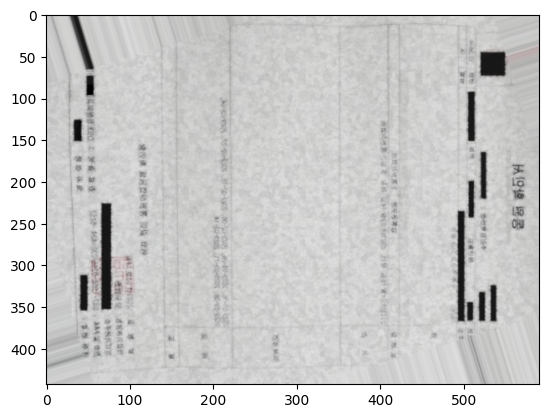

In [7]:
image_path = "/home/pervinco/upstage-cv-classification-cv7/runs/best_9564/incorrect/pred3_gt7_2ba15d167da0458b.jpg"
coord_path = "/home/pervinco/upstage-cv-classification-cv7/dataset/test_with_bbox/res_2ba15d167da0458b.txt"

image = cv2.imread(image_path)
plt.imshow(image)

image = deskew(image)
plt.imshow(image)

/home/pervinco/miniconda3/envs/cls-project/lib/python3.9/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


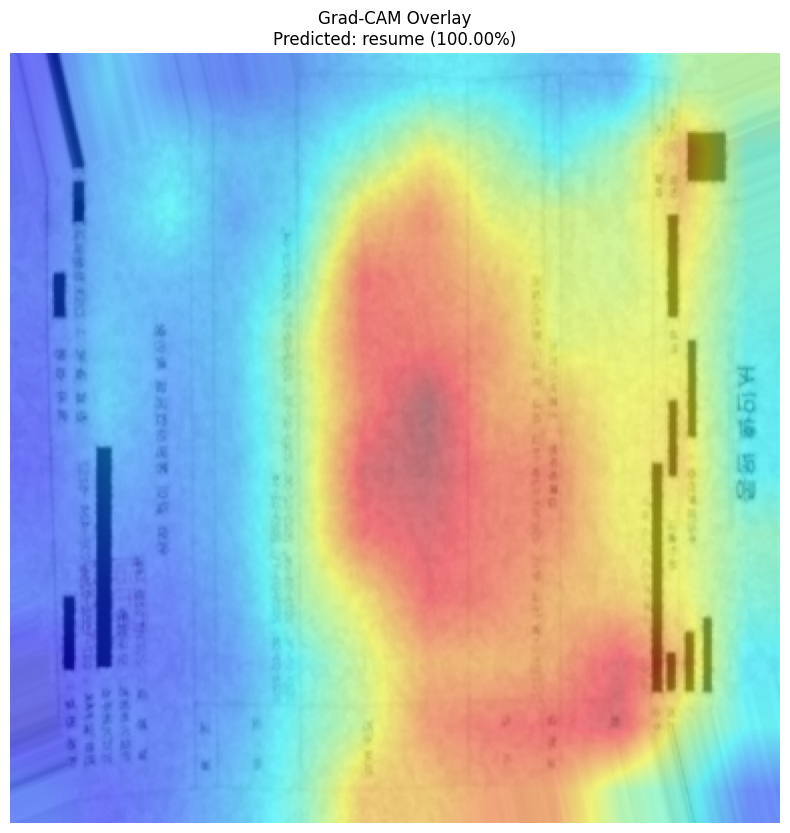

In [8]:
## 전체 이미지.
x = transform(image=image)['image']
plot_grad_cam(model, x, class_names=classes, overlay=True)

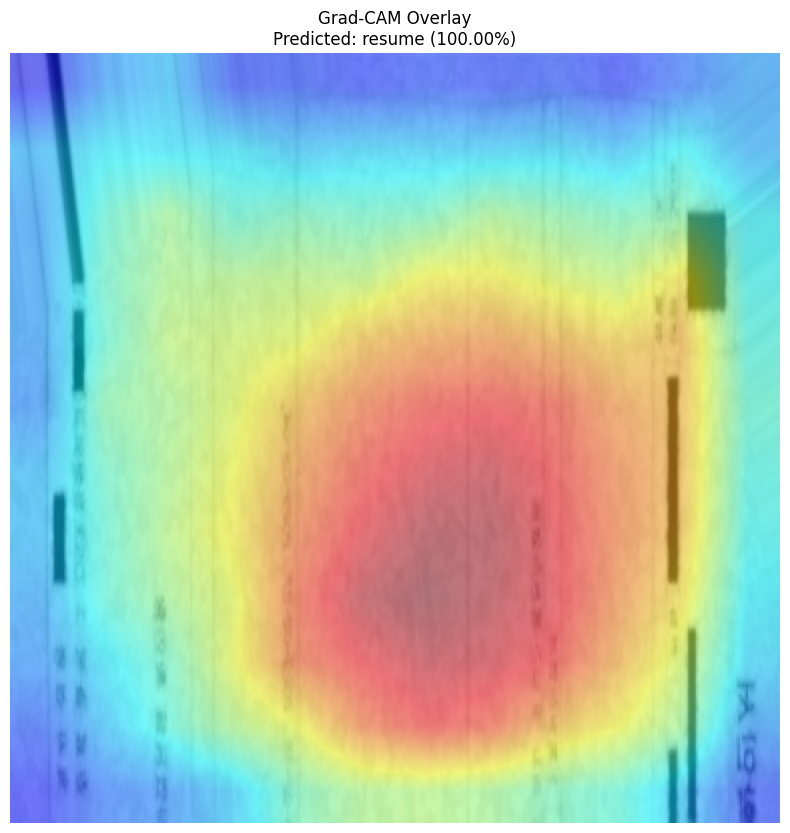

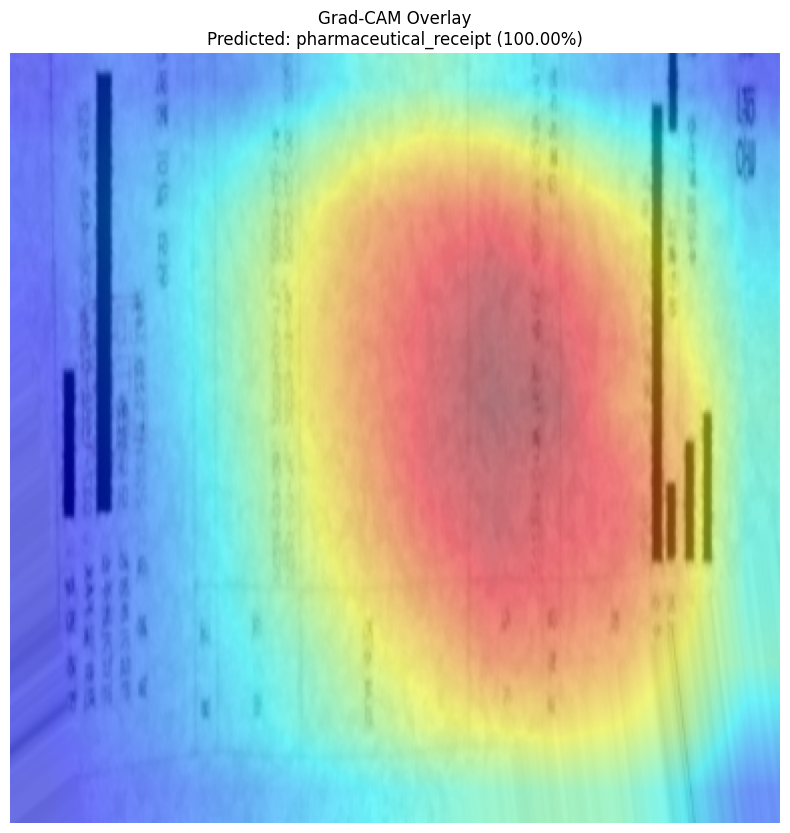

In [9]:
## 2분할
def half_divide(image):
    height, width, _ = image.shape    
    center_y = height // 2

    top_half = image[0:center_y, :]
    bottom_half = image[center_y:height, :]

    return top_half, bottom_half

top, bottom = half_divide(image)
top_x = transform(image=top)['image']
bottom_x = transform(image=bottom)['image']

plot_grad_cam(model, top_x, class_names=classes, overlay=True)
plot_grad_cam(model, bottom_x, class_names=classes, overlay=True)

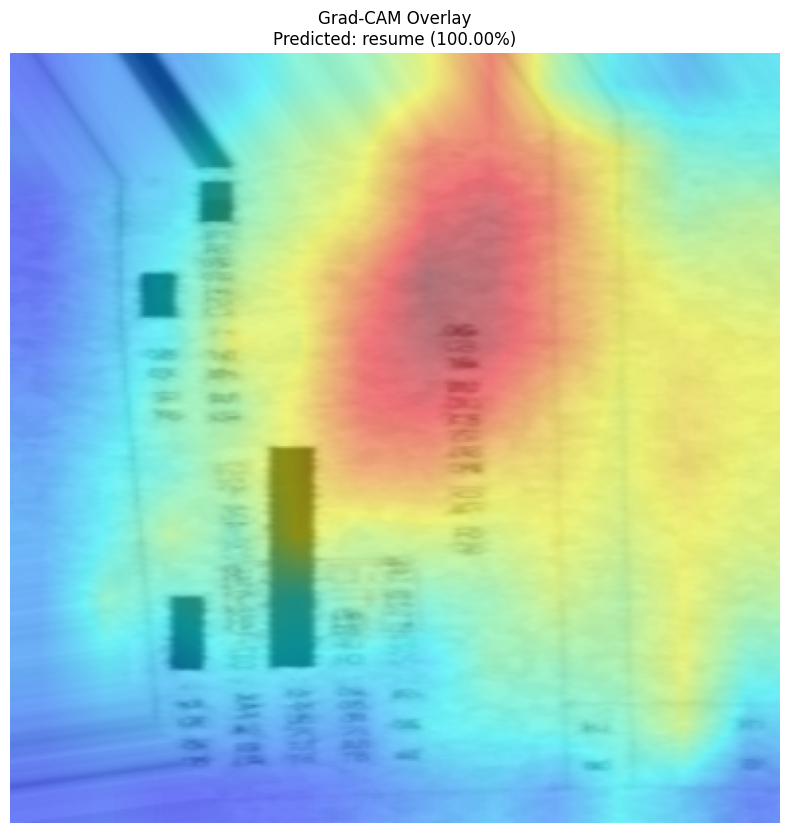

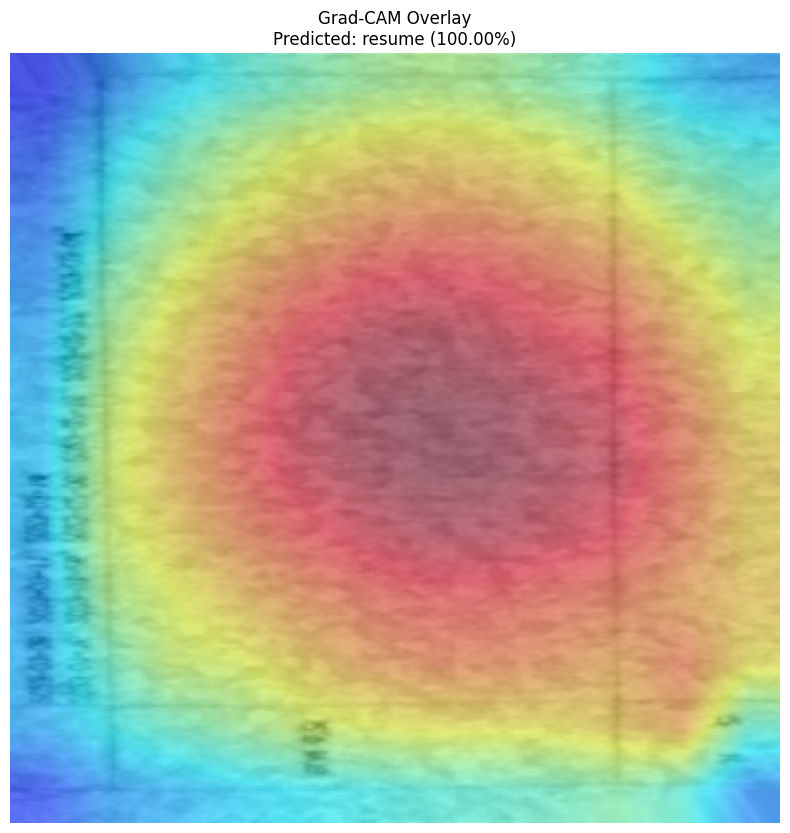

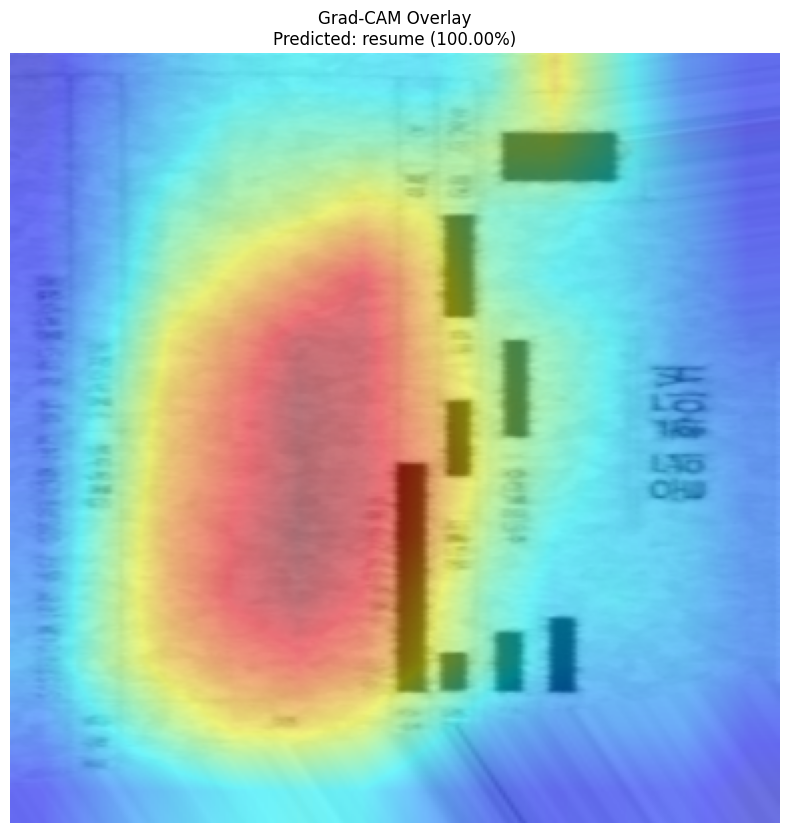

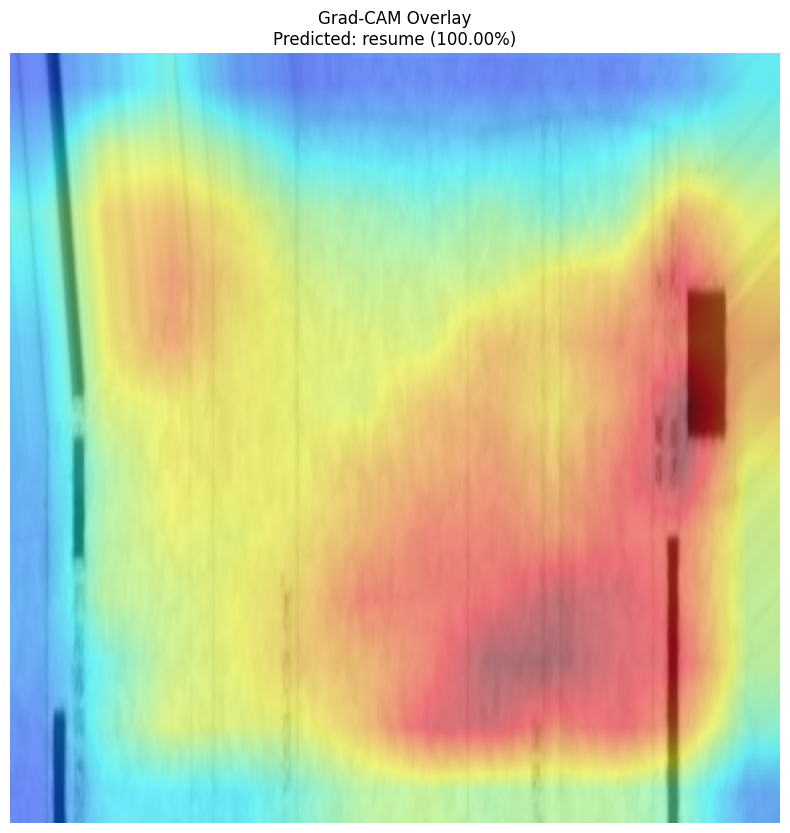

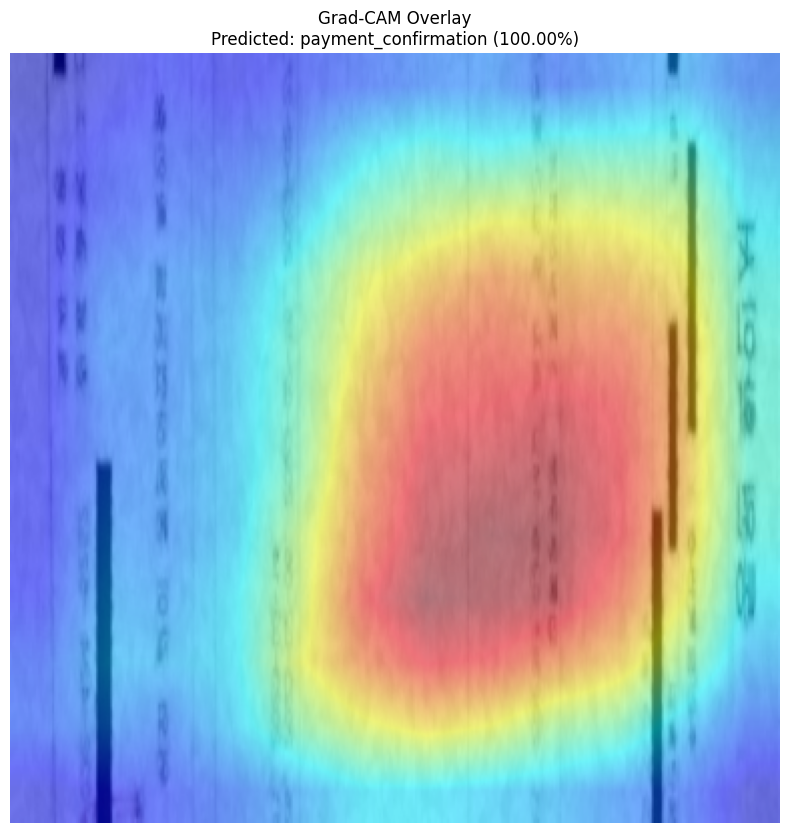

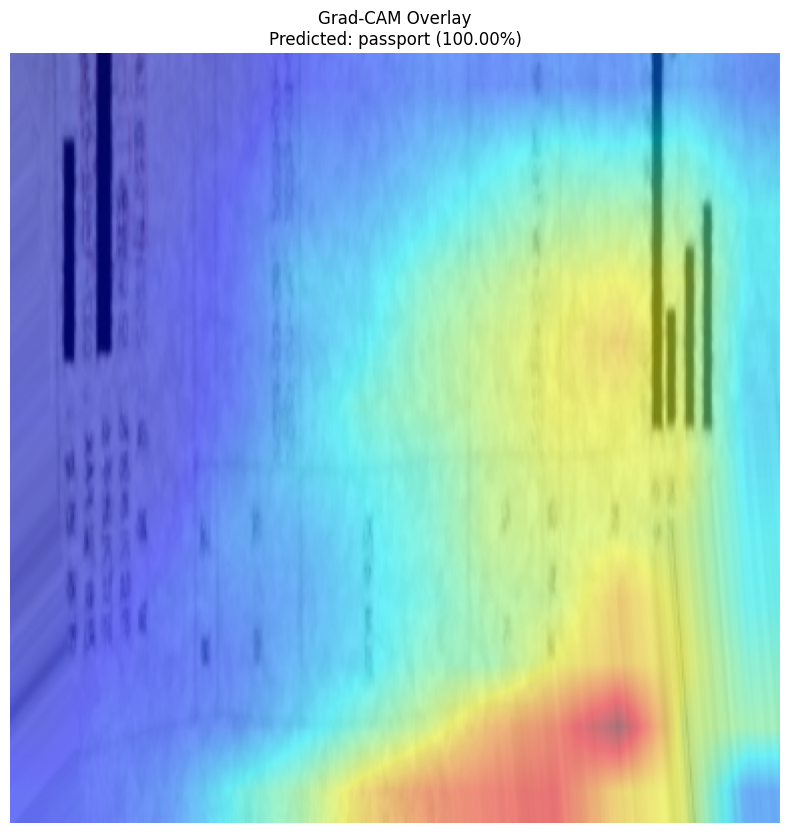

In [10]:
def split_image(image):   
    height, width = image.shape[:2]
    
    h_split = np.array_split(image, 3, axis=1)
    v_split = np.array_split(image, 3, axis=0)
    
    result = []
    for h_img in h_split:
        result.append(h_img)
    
    for v_img in v_split:
        result.append(v_img)
    
    return result

blocks = split_image(image)
for block in blocks:
    x = transform(image=block)['image']
    plot_grad_cam(model, x, class_names=classes, overlay=True)    

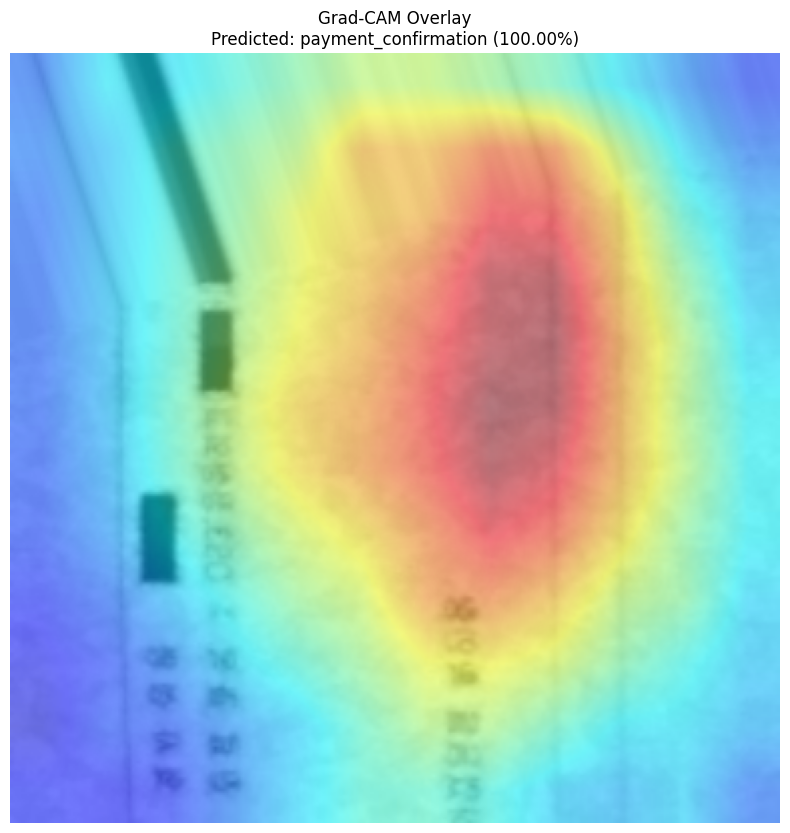

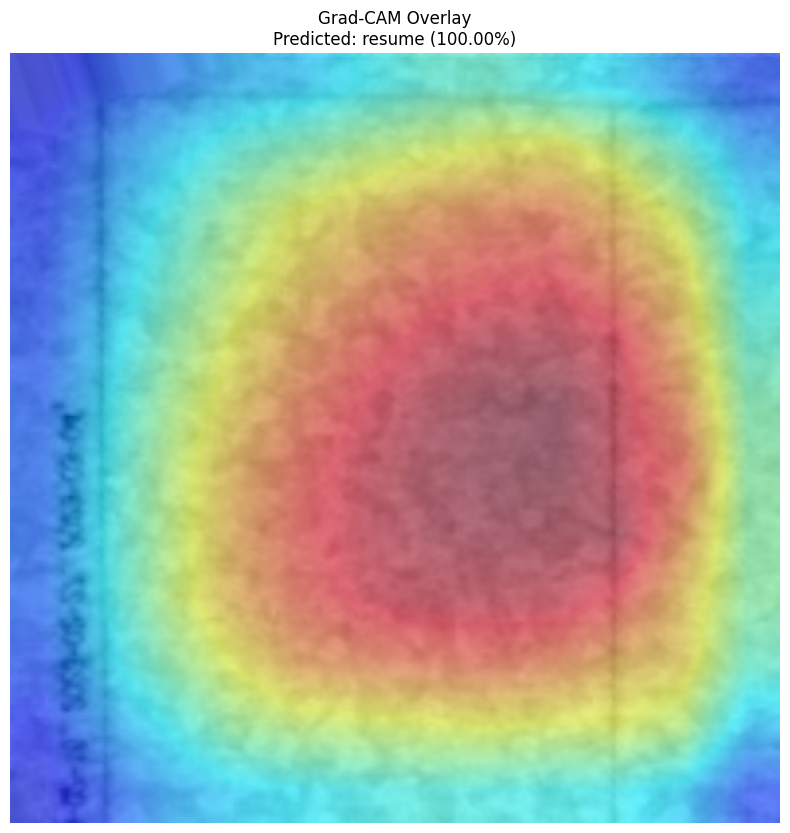

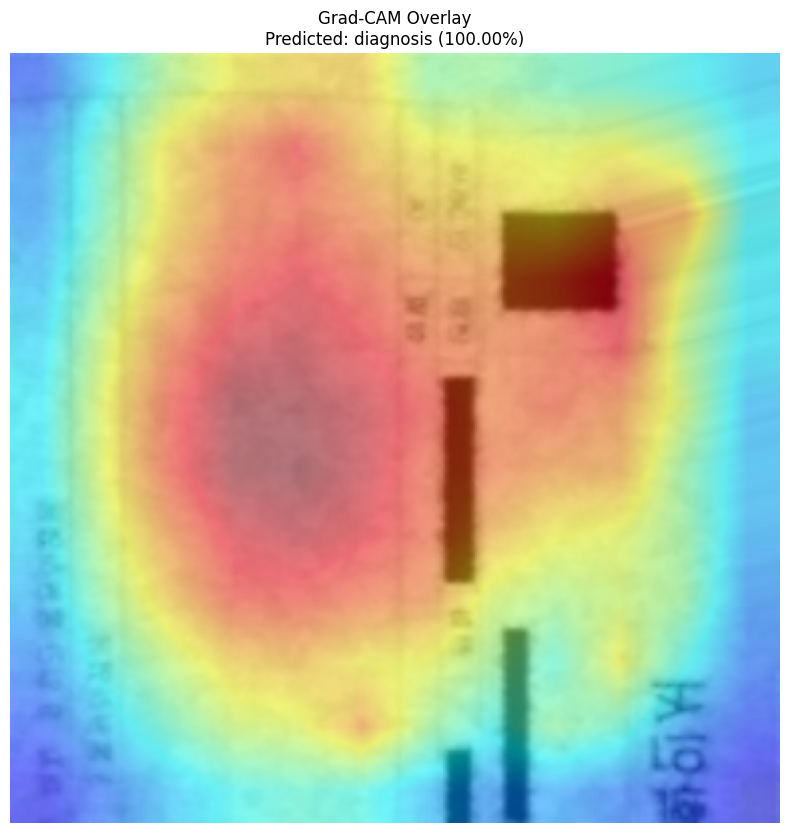

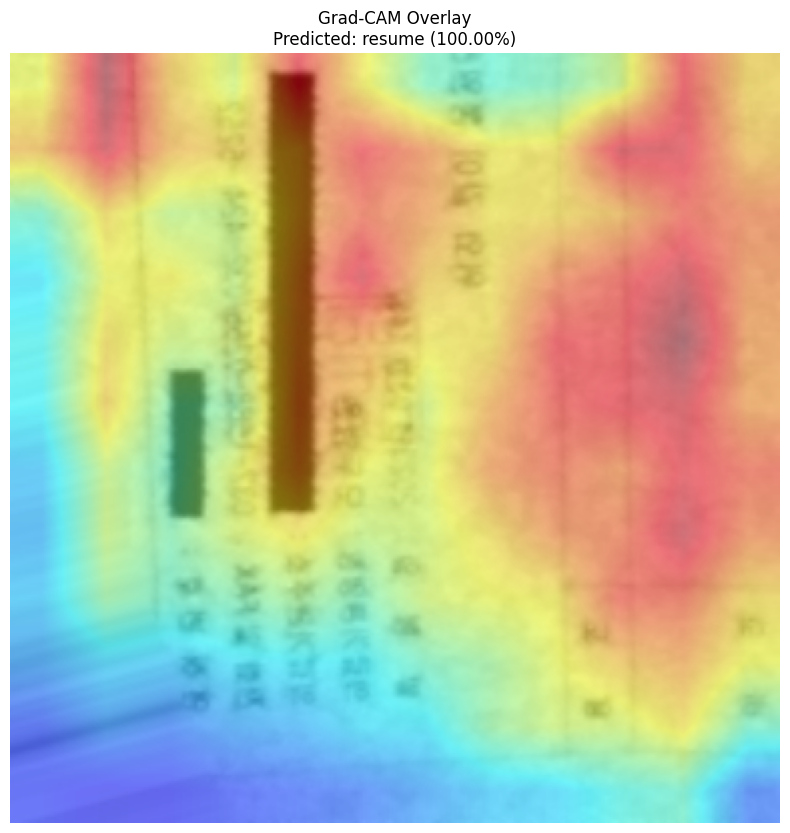

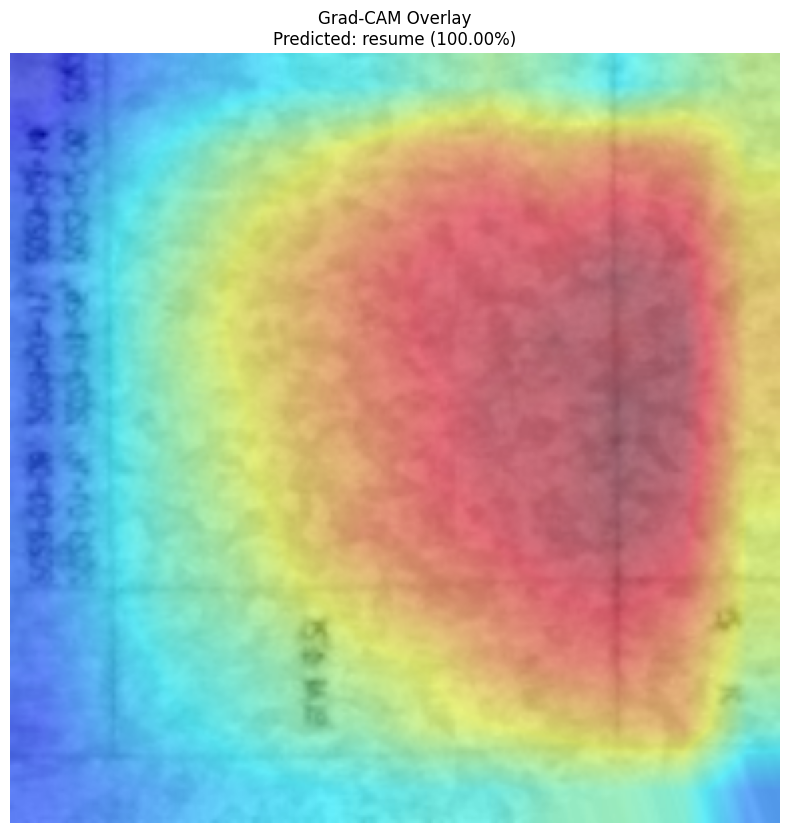

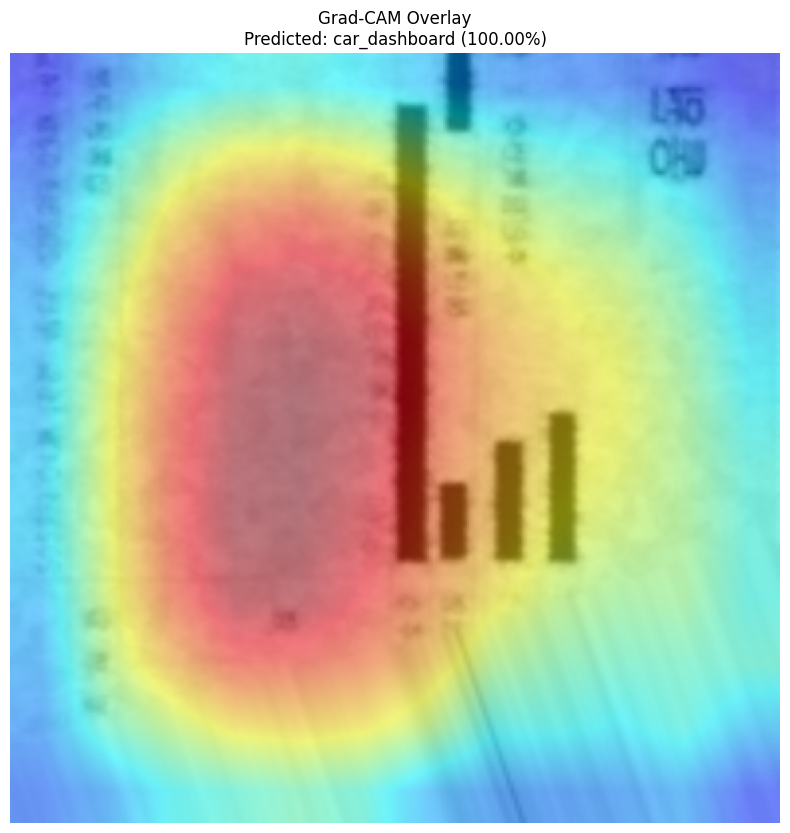

In [11]:
## 6분할
def divide_six_parts(image):
    height, width = image.shape[:2]

    block_height = height // 2
    block_width = width // 3

    block_1 = image[:block_height, :block_width]
    block_2 = image[:block_height, block_width:2*block_width]
    block_3 = image[:block_height, 2*block_width:]
    block_4 = image[block_height:, :block_width]
    block_5 = image[block_height:, block_width:2*block_width]
    block_6 = image[block_height:, 2*block_width:]

    return block_1, block_2, block_3, block_4, block_5, block_6

blocks = divide_six_parts(image)
for block in blocks:
    x = transform(image=block)['image']
    plot_grad_cam(model, x, class_names=classes, overlay=True)

In [12]:
def read_coordinates_from_file(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file if line.strip()]


def augment_text_regions(image_path, coordinate_path, output_path=None, num_augmentations=1):
    image = cv2.imread(image_path)
    coords = read_coordinates_from_file(coordinate_path)

    for i in range(num_augmentations):
        avg_color = np.mean(image, axis=(0, 1)).astype(int)
        background_color = avg_color + np.random.randint(-20, 21, 3) 
        background_color = np.clip(background_color, 0, 255)
        
        h, w = image.shape[:2]
        background = np.zeros((h, w, 3), dtype=np.uint8)
        for c in range(3):
            background[:, :, c] = np.linspace(background_color[c] - 30, background_color[c] + 30, w)
        
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        for coord in coords:
            x1, y1, x2, y2, x3, y3, x4, y4 = map(int, coord.split(','))
            
            pts = np.array([[x1,y1], [x2,y2], [x3,y3], [x4,y4]], np.int32)
            pts = pts.reshape((-1,1,2))
            cv2.fillPoly(mask, [pts], (255))

        blurred_mask = cv2.GaussianBlur(mask, (21, 21), 0)
        blurred_mask = blurred_mask.reshape(h, w, 1) / 255.0

        text_regions = image * blurred_mask
        background = background * (1 - blurred_mask)
        result = text_regions + background

        if not output_path is None:
            output_file = os.path.join(output_path, f"augmented_{i}.png")
            cv2.imwrite(output_file, result.astype(np.uint8))
        else:
            return result.astype(np.uint8)

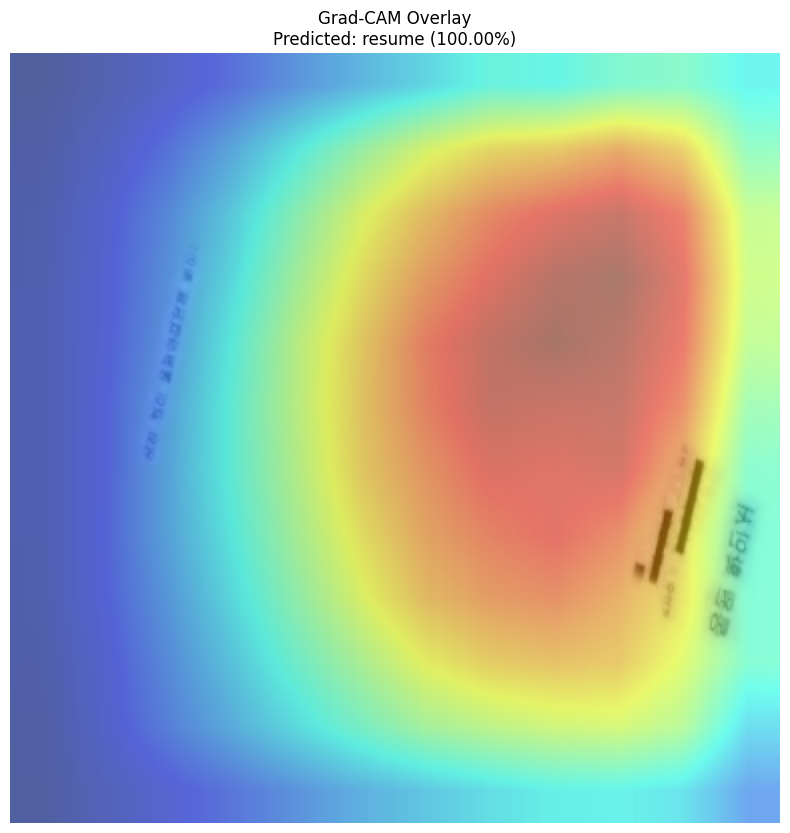

In [13]:
image = augment_text_regions(image_path, coord_path)
x = transform(image=image)['image']
plot_grad_cam(model, x, class_names=classes, overlay=True)